### Validation schema

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

In [2]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [3]:
# add data path to sys.path 
train_test_data_path = "C:\\Repository\\DS-Intership-data\\train_test_data\\"
sys.path.append(train_test_data_path)

# initiate dict for data
to_read_train_test_data = {}

# fill to_read
for dir_name, _, files in os.walk(train_test_data_path):
    for file in files:
        to_read_train_test_data[file] = dir_name + file

In [4]:
# check to_read
to_read_train_test_data

{'sample_submission.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\sample_submission.csv',
 'submission_example.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\submission_example.csv',
 'test_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\test_data.csv',
 'train_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\train_data.csv'}

In [5]:
%%time
data = {}
# read data
for file, path in to_read_train_test_data.items():
    data[file.split('.')[0]] = pd.read_csv(os.path.join(os.path.dirname(path), file), index_col=0)

CPU times: total: 42 s
Wall time: 47.3 s


### Validation schema creation

In [29]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        split_history = {
            'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
            'Train Data': [], 
            'Validation Data': []
        }
        for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
            split_history['Train Data'].append(train.max()-train.min())
            split_history['Validation Data'].append(val.max()-val.min())
        df = pd.DataFrame(split_history)
        print(df)
        sns.set(style="whitegrid")
        plt.figure(figsize=(6, 5))
        sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
        sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
        plt.title('Distribution of data for training and validation')
        plt.xlabel('Validation step')
        plt.ylabel('Data quantity')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def fit_predict(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def evaluate(self, predictions_by_ID = True):
        
        eval_report = {}
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(self.y):
            step += 1

            # Split data step
            y_tr, y_val = self.y.iloc[train], self.y.iloc[val]
            X_tr, X_val = self.X.iloc[train], self.X.iloc[val]

            # Train step
            rng = np.random.RandomState(42)
            model = self.model
            model.fit(X_tr.values, y_tr.item_cnt_month.values)

            # Evaluation step
            y_tr_pr = pd.DataFrame(index=X_tr.index, data=model.predict(X_tr.values), columns=['item_cnt_month'])
            y_val_pr = pd.DataFrame(index=X_val.index, data=model.predict(X_val.values), columns=['item_cnt_month'])
            
            # Extract step (predictions by ID)
            if predictions_by_ID:
                nan_report = {}
                y_tr = y_tr.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train'] = f"{y_tr.item_cnt_month.isna().sum() / y_tr.shape[0] * 100} %"
                y_tr = y_tr.fillna(0)
                y_val = y_val.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val'] = f"{y_val.item_cnt_month.isna().sum() / y_val.shape[0] * 100} %"
                y_val = y_val.fillna(0)
                y_tr_pr = X_tr.join(y_tr_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train_pred'] = f"{y_tr_pr.item_cnt_month.isna().sum() / y_tr_pr.shape[0] * 100} %"
                y_tr_pr = y_tr_pr.fillna(0)
                y_val_pr = X_val.join(y_val_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val_pred'] = f"{y_val_pr.item_cnt_month.isna().sum() / y_val_pr.shape[0] * 100} %"
                y_val_pr = y_val_pr.fillna(0)
                
            # Metrics calucaltion step
            eval_report["step"+str(step)] = {
                "train/validation limits" : f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " +
                                      f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )",
                "train/validation error" : [self.calculate_metrics(y_tr_pr.item_cnt_month, y_tr.item_cnt_month),
                           self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month)],
                "feature_importance" : model.feature_importances_,
                "nan_report" : nan_report,
                "__________________" : "_________________________________________________________________________________"
            }
            
        return eval_report     

    Step  Train Data  Validation Data
0  Step1     3064035          3064032
1  Step2     6128068          3064032
2  Step3     9192101          3064032
3  Step4    12256134          3064032
4  Step5    15320167          3064032


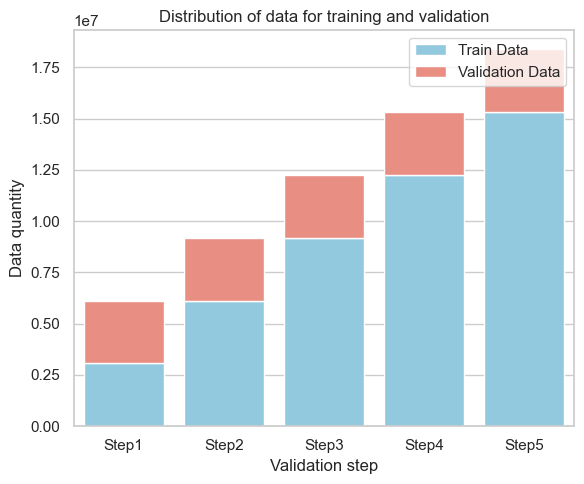

CPU times: total: 3.69 s
Wall time: 4.33 s


In [36]:
%%time
test_validation_class = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=5,
                 model = DecisionTreeRegressor(max_depth=2, random_state=42),
                 check_nans=False
                )

In [24]:
%%time
test_validation_class.evaluate()

CPU times: total: 2min 38s
Wall time: 2min 51s


{'step1': {'train/validation limits': 'TRAIN: from 0 to  3064035  (size: 3064035 ) VALIDATION: from 3064036 to  6128068  (size: 3064032 )',
  'train/validation error': [8.840776255462112, 10.474542286767196],
  'feature_importance': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.15056817, 0.84943183, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]),
  'nan_report': {'y_train': '30.33070299735861 %',
   'y_val': '24.270336415887144 %',
   'y_train_pred': '30.33070299735861 %',
   'y_val_pred': '24.270336415887144 %'},
  '__________________': '_________________________________________________________________________________'},
 'step2': {'train/validation limits': '

In [25]:
%%time
test_validation_class.fit_predict()

CPU times: total: 50.6 s
Wall time: 54.9 s


,ID,item_cnt_month
0,0,0.33
2,1,0.33
3,2,0.33
5,3,0.33
7,4,0.33
...,...,...
309449,214195,0.33
309450,214196,0.33
309451,214197,0.33
309452,214198,0.33


### Learn models

##### Random Forest Regressor

    Step  Train Data  Validation Data
0  Step1      639033           639028
1  Step2     1278062           639028
2  Step3     1917091           639028
3  Step4     2556120           639028
4  Step5     3195149           639028


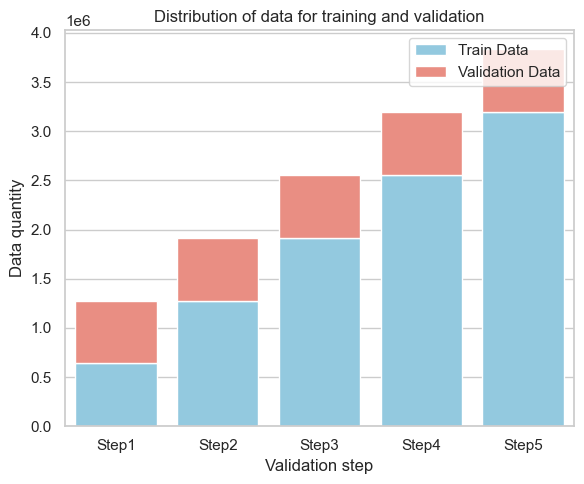

In [56]:
%%time
random_forest_regression = Validation(
                                 train_data=data['train_data'],
                                 test_data=data['test_data'],
                                 submission_example=data['submission_example'],
                                 n_splits=5,
                                 model = RandomForestRegressor(max_depth=4, n_estimators=25, random_state=42),
                                 check_nans=True,
                                 dropna = True
                           )

In [60]:
%%time
random_forest_regression.evaluate()

In [ ]:
%%time
RandomForest_regression_submission = random_forest_regression.fit_predict()

##### XGboost

    Step  Train Data  Validation Data
0  Step1      639033           639028
1  Step2     1278062           639028
2  Step3     1917091           639028
3  Step4     2556120           639028
4  Step5     3195149           639028


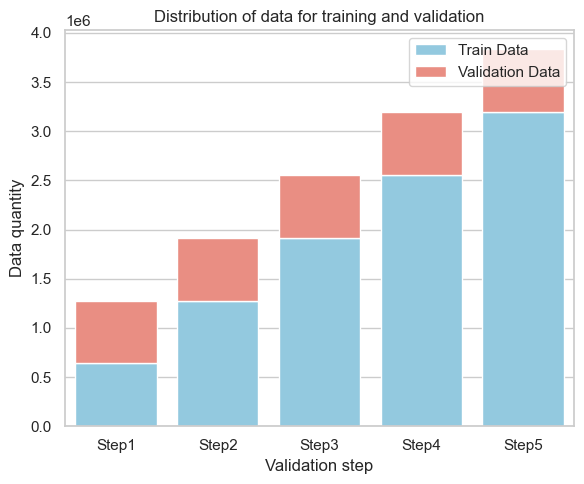

In [11]:
%%time
XGB_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=5,
                     model = XGBRegressor(),
                     check_nans=True,
                     dropna = True
                 ) 

In [14]:
%%time
XGB_regression.evaluate()

In [ ]:
%%time
XGB_regression_submission = XGB_regression.fir_predict()

##### LightGBM

    Step  Train Data  Validation Data
0  Step1      639033           639028
1  Step2     1278062           639028
2  Step3     1917091           639028
3  Step4     2556120           639028
4  Step5     3195149           639028


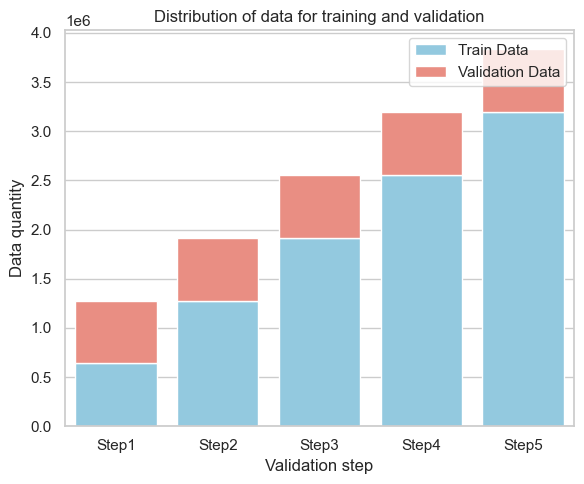

In [25]:
%%time

# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': ['rmse']
# }

LightGBM_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=5,
                     model = lgb.LGBMRegressor(),
                     check_nans=True,
                     dropna = True
                 ) 

In [26]:
%%time
LightGBM_regression.evaluate()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 639034, number of used features: 32
[LightGBM] [Info] Start training from score 0.314916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3154
[LightGBM] [Info] Number of data points in the train set: 1278063, number of used features: 32
[LightGBM] [Info] Start training from score 0.314282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

{'step1': {'train/validation limits': 'TRAIN: from 0 to  639033  (size: 639033 ) VALIDATION: from 639034 to  1278062  (size: 639028 )',
  'train/validation error': [0.623786501097354, 5.1342577370061555],
  'feature_importance': array([ 16,  91, 125,  57,   0,  46,   0,  45,  81,  23, 328, 292, 170,
         206,   2,  25,   2,   2, 303, 159, 146, 152, 149,  86,  86, 144,
         219,   6,   0,  21,  14,   4]),
  'nan_report': {'y_train': '31.005330104297375 %',
   'y_val': '24.223668538369918 %',
   'y_train_pred': '31.005330104297375 %',
   'y_val_pred': '24.223668538369918 %'},
  '__________________': '_________________________________________________________________________________'},
 'step2': {'train/validation limits': 'TRAIN: from 0 to  1278062  (size: 1278062 ) VALIDATION: from 1278063 to  1917091  (size: 639028 )',
  'train/validation error': [0.9557505633802278, 5.222021631206538],
  'feature_importance': array([ 47, 104,  89,  36,   0,  42,   0,  39,  52,  23, 364, 282, 21

In [28]:
%%time
LightGBM_regression_submission = LightGBM_regression.fit_predict()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 3834179, number of used features: 32
[LightGBM] [Info] Start training from score 0.355619


ID                     0
item_cnt_month    139867
dtype: int64

##### Catboost

In [8]:
%%time
catboost_regression = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 n_splits=5,
                 model = cb.CatBoostRegressor(),
                 check_nans=False
                )

In [11]:
%%time
CatBoost_regression_submission = catboost_regression.fit_predict()

Learning rate set to 0.146202
0:	learn: 1.9814178	total: 247ms	remaining: 4m 7s
1:	learn: 1.8776953	total: 447ms	remaining: 3m 42s
2:	learn: 1.7940542	total: 645ms	remaining: 3m 34s
3:	learn: 1.7291765	total: 846ms	remaining: 3m 30s
4:	learn: 1.6781121	total: 1.04s	remaining: 3m 27s
5:	learn: 1.6388386	total: 1.25s	remaining: 3m 26s
6:	learn: 1.6071324	total: 1.45s	remaining: 3m 25s
7:	learn: 1.5826737	total: 1.65s	remaining: 3m 24s
8:	learn: 1.5601197	total: 1.87s	remaining: 3m 26s
9:	learn: 1.5404668	total: 2.09s	remaining: 3m 26s
10:	learn: 1.5255648	total: 2.29s	remaining: 3m 26s
11:	learn: 1.5124257	total: 2.51s	remaining: 3m 26s
12:	learn: 1.5023539	total: 2.73s	remaining: 3m 27s
13:	learn: 1.4947364	total: 2.94s	remaining: 3m 27s
14:	learn: 1.4865521	total: 3.15s	remaining: 3m 26s
15:	learn: 1.4789800	total: 3.36s	remaining: 3m 26s
16:	learn: 1.4741561	total: 3.57s	remaining: 3m 26s
17:	learn: 1.4670175	total: 3.78s	remaining: 3m 26s
18:	learn: 1.4619130	total: 4s	remaining: 3m 

159:	learn: 1.3191551	total: 33.5s	remaining: 2m 56s
160:	learn: 1.3170574	total: 33.7s	remaining: 2m 55s
161:	learn: 1.3162426	total: 34s	remaining: 2m 55s
162:	learn: 1.3159248	total: 34.2s	remaining: 2m 55s
163:	learn: 1.3156720	total: 34.4s	remaining: 2m 55s
164:	learn: 1.3152647	total: 34.6s	remaining: 2m 55s
165:	learn: 1.3148922	total: 34.8s	remaining: 2m 54s
166:	learn: 1.3146020	total: 35s	remaining: 2m 54s
167:	learn: 1.3141546	total: 35.2s	remaining: 2m 54s
168:	learn: 1.3135861	total: 35.4s	remaining: 2m 54s
169:	learn: 1.3133678	total: 35.7s	remaining: 2m 54s
170:	learn: 1.3132113	total: 35.9s	remaining: 2m 53s
171:	learn: 1.3129005	total: 36.1s	remaining: 2m 53s
172:	learn: 1.3122048	total: 36.3s	remaining: 2m 53s
173:	learn: 1.3120459	total: 36.5s	remaining: 2m 53s
174:	learn: 1.3116444	total: 36.7s	remaining: 2m 52s
175:	learn: 1.3113845	total: 36.9s	remaining: 2m 52s
176:	learn: 1.3112287	total: 37.1s	remaining: 2m 52s
177:	learn: 1.3108536	total: 37.3s	remaining: 2m 5

316:	learn: 1.2681805	total: 1m 7s	remaining: 2m 25s
317:	learn: 1.2679919	total: 1m 7s	remaining: 2m 24s
318:	learn: 1.2678928	total: 1m 7s	remaining: 2m 24s
319:	learn: 1.2677473	total: 1m 7s	remaining: 2m 24s
320:	learn: 1.2676654	total: 1m 8s	remaining: 2m 24s
321:	learn: 1.2670336	total: 1m 8s	remaining: 2m 24s
322:	learn: 1.2668470	total: 1m 8s	remaining: 2m 23s
323:	learn: 1.2667548	total: 1m 8s	remaining: 2m 23s
324:	learn: 1.2666669	total: 1m 9s	remaining: 2m 23s
325:	learn: 1.2662214	total: 1m 9s	remaining: 2m 23s
326:	learn: 1.2659508	total: 1m 9s	remaining: 2m 22s
327:	learn: 1.2657963	total: 1m 9s	remaining: 2m 22s
328:	learn: 1.2654418	total: 1m 9s	remaining: 2m 22s
329:	learn: 1.2653474	total: 1m 10s	remaining: 2m 22s
330:	learn: 1.2652022	total: 1m 10s	remaining: 2m 22s
331:	learn: 1.2651099	total: 1m 10s	remaining: 2m 22s
332:	learn: 1.2650171	total: 1m 10s	remaining: 2m 21s
333:	learn: 1.2649341	total: 1m 11s	remaining: 2m 21s
334:	learn: 1.2644357	total: 1m 11s	remai

470:	learn: 1.2402052	total: 1m 42s	remaining: 1m 55s
471:	learn: 1.2401548	total: 1m 43s	remaining: 1m 55s
472:	learn: 1.2401032	total: 1m 43s	remaining: 1m 55s
473:	learn: 1.2397987	total: 1m 43s	remaining: 1m 54s
474:	learn: 1.2397574	total: 1m 43s	remaining: 1m 54s
475:	learn: 1.2396081	total: 1m 43s	remaining: 1m 54s
476:	learn: 1.2394835	total: 1m 44s	remaining: 1m 54s
477:	learn: 1.2393401	total: 1m 44s	remaining: 1m 54s
478:	learn: 1.2392479	total: 1m 44s	remaining: 1m 53s
479:	learn: 1.2390721	total: 1m 44s	remaining: 1m 53s
480:	learn: 1.2389985	total: 1m 45s	remaining: 1m 53s
481:	learn: 1.2387917	total: 1m 45s	remaining: 1m 53s
482:	learn: 1.2385585	total: 1m 45s	remaining: 1m 53s
483:	learn: 1.2384982	total: 1m 45s	remaining: 1m 52s
484:	learn: 1.2384494	total: 1m 46s	remaining: 1m 52s
485:	learn: 1.2383883	total: 1m 46s	remaining: 1m 52s
486:	learn: 1.2382408	total: 1m 46s	remaining: 1m 52s
487:	learn: 1.2381621	total: 1m 46s	remaining: 1m 51s
488:	learn: 1.2380122	total:

623:	learn: 1.2195219	total: 2m 20s	remaining: 1m 24s
624:	learn: 1.2194571	total: 2m 21s	remaining: 1m 24s
625:	learn: 1.2194264	total: 2m 21s	remaining: 1m 24s
626:	learn: 1.2193763	total: 2m 21s	remaining: 1m 24s
627:	learn: 1.2193466	total: 2m 21s	remaining: 1m 23s
628:	learn: 1.2192637	total: 2m 22s	remaining: 1m 23s
629:	learn: 1.2190675	total: 2m 22s	remaining: 1m 23s
630:	learn: 1.2189569	total: 2m 22s	remaining: 1m 23s
631:	learn: 1.2188979	total: 2m 22s	remaining: 1m 23s
632:	learn: 1.2188614	total: 2m 23s	remaining: 1m 22s
633:	learn: 1.2184685	total: 2m 23s	remaining: 1m 22s
634:	learn: 1.2183716	total: 2m 23s	remaining: 1m 22s
635:	learn: 1.2183077	total: 2m 23s	remaining: 1m 22s
636:	learn: 1.2182192	total: 2m 24s	remaining: 1m 22s
637:	learn: 1.2181949	total: 2m 24s	remaining: 1m 21s
638:	learn: 1.2181140	total: 2m 24s	remaining: 1m 21s
639:	learn: 1.2180584	total: 2m 24s	remaining: 1m 21s
640:	learn: 1.2175278	total: 2m 25s	remaining: 1m 21s
641:	learn: 1.2167514	total:

777:	learn: 1.2042485	total: 3m	remaining: 51.4s
778:	learn: 1.2042255	total: 3m	remaining: 51.2s
779:	learn: 1.2041960	total: 3m	remaining: 51s
780:	learn: 1.2041731	total: 3m 1s	remaining: 50.8s
781:	learn: 1.2041495	total: 3m 1s	remaining: 50.6s
782:	learn: 1.2040574	total: 3m 1s	remaining: 50.4s
783:	learn: 1.2040280	total: 3m 2s	remaining: 50.2s
784:	learn: 1.2040050	total: 3m 2s	remaining: 50s
785:	learn: 1.2039795	total: 3m 2s	remaining: 49.8s
786:	learn: 1.2035470	total: 3m 3s	remaining: 49.5s
787:	learn: 1.2031403	total: 3m 3s	remaining: 49.3s
788:	learn: 1.2029638	total: 3m 3s	remaining: 49.1s
789:	learn: 1.2029337	total: 3m 3s	remaining: 48.9s
790:	learn: 1.2028973	total: 3m 4s	remaining: 48.7s
791:	learn: 1.2028549	total: 3m 4s	remaining: 48.4s
792:	learn: 1.2028302	total: 3m 4s	remaining: 48.2s
793:	learn: 1.2027849	total: 3m 5s	remaining: 48s
794:	learn: 1.2027569	total: 3m 5s	remaining: 47.8s
795:	learn: 1.2026034	total: 3m 5s	remaining: 47.6s
796:	learn: 1.2025613	total

933:	learn: 1.1913389	total: 3m 45s	remaining: 16s
934:	learn: 1.1913025	total: 3m 46s	remaining: 15.7s
935:	learn: 1.1912725	total: 3m 46s	remaining: 15.5s
936:	learn: 1.1912441	total: 3m 46s	remaining: 15.3s
937:	learn: 1.1911297	total: 3m 47s	remaining: 15s
938:	learn: 1.1910900	total: 3m 47s	remaining: 14.8s
939:	learn: 1.1909609	total: 3m 47s	remaining: 14.5s
940:	learn: 1.1909319	total: 3m 48s	remaining: 14.3s
941:	learn: 1.1909050	total: 3m 48s	remaining: 14.1s
942:	learn: 1.1908414	total: 3m 48s	remaining: 13.8s
943:	learn: 1.1907868	total: 3m 48s	remaining: 13.6s
944:	learn: 1.1907605	total: 3m 49s	remaining: 13.3s
945:	learn: 1.1907353	total: 3m 49s	remaining: 13.1s
946:	learn: 1.1907057	total: 3m 49s	remaining: 12.9s
947:	learn: 1.1906667	total: 3m 50s	remaining: 12.6s
948:	learn: 1.1905338	total: 3m 50s	remaining: 12.4s
949:	learn: 1.1905211	total: 3m 50s	remaining: 12.1s
950:	learn: 1.1904377	total: 3m 50s	remaining: 11.9s
951:	learn: 1.1903633	total: 3m 51s	remaining: 11.

### Сomparison of models based on validation results

In [ ]:
### add table with validation results

### Save submission results

In [32]:
submission_data = {
    'RF_submission' : RandomForest_regression_submission,
    'XGB_submission' : XGB_regression_submission,
    'LightGBM_submission' : LightGBM_regression_submission,
    'CatBoost_submission' : CatBoost_regression_submission
}

NameError: name 'RandomForest_regression_submission' is not defined

In [ ]:
%%time
# add path to load to sys.path 
path_to_load = "C:\\Repository\\DS-Intership-data\\baseline_submissions\\"
os.makedirs(path_to_load, exist_ok=True)
sys.path.append(path_to_load)

# load data 
for file, df in cluster_data.items():
    df.to_csv(path_to_load+file+".csv", index=False)

In [ ]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

In [33]:
### add table with submission results